# Bone Fracture Detection
*Updated: 27/10/2024*

*Reference 1: Nirmal Gaud*

*Reference 2: https://www.kaggle.com/datasets/pkdarabi/bone-fracture-detection-computer-vision-project*

## Introduction
This Jupyter Notebook explores computer vision (CV) tasks for automated bone fracture detection in X-ray images. Manual X-ray analysis for fracture detection is time-consuming and prone to human error. This project aims to develop an automated system for accurate fracture detection, potentially improving healthcare efficiency and reducing misdiagnosis.

**Dataset:**
The notebook utilizes a dataset containing images categorized as "Fractured" and "Not Fractured." This allows the model to learn the visual characteristics associated with bone fractures in X-rays.

**Content:**
This notebook covers the following:
1. Data Exploration: Visualization of sample images from the training, validation, and test sets.
2. Data Preprocessing: Defining a custom dataset class and applying data transformations for training.
3. Model Building: Employing a pre-trained ResNet18 model for image classification with a modified final layer for binary classification (fracture vs. no fracture).
4. Training and Evaluation: Training the model on the prepared data and evaluating its performance on the validation set.

### Set up Kaggle Notebook environment
This tutorial is done using the Kaggle Notebook environement, where you can run Python or R code, access datasets, and leverage GPUs/TPUs. 

**Create a New Kaggle Notebook:**
Go to Kaggle, log in, and select "New Notebook" from the "Code" section.

**Add Your Dataset:**
On the right-hand side of the notebook interface, click on "Add Data".
Search for your dataset, i.e. "bone-fracture-detection-computer-visionproject", and add it to the notebook.
This will mount the dataset in the /kaggle/input/ directory, where it’s accessible for use.

# Part I: Displaying images from datasets
This section focuses on loading and displaying a sample of images from specified directories for training, validation, and testing. This helps in visualizing the dataset and verifying its contents.

### Import Libraries

In [19]:
# Import necessary libraries and packages
import matplotlib.pyplot as plt
import seaborn as sns
import random
import PIL
import PIL.Image
import os

### Paths to Data

In [20]:
# Define dataset directories
# Kaggle mounts the dataset in a specific directory
# Click on an image file from one of your dataset and the image and path will display in the terminal
train_dir = '/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/train/images'
val_dir = '/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/valid/images'
test_dir = '/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/test/images'


In [21]:
# Confirm that dataset paths exists
if os.path.exists(test_dir):
    print("The path exists.")
else:
    print("The path does not exist.")

The path exists.


### Display Function
Defines a function that displays a sample of images from a specified directory. It collects image files, adjusts the sample size if fewer images are available, randomly selects images, and configures a grid for display using Matplotlib.

In [22]:
from PIL import Image

# Define function to display a sample of images from a directory
def display_images(image_dir, num_images=10):
    image_files = [f for f in os.listdir(image_dir) if f.endswith(('jpg', 'jpeg', 'png'))]
    
    # Adjust number of images if less than requested
    if len(image_files) < num_images:
        num_images = len(image_files)
        print(f"Warning: Only {num_images} images available in {image_dir}")
    
    # Randomly select imags to display
    selected_images = random.sample(image_files, num_images)
    
    # Set up a grid for displaying images
    cols = 5
    rows = (num_images + cols - 1) // cols

    # Configure the plot size
    plt.figure(figsize=(15, rows * 3))
    
    # Loop through selected images and display each one
    for i, image_file in enumerate(selected_images):
        img_path = os.path.join(image_dir, image_file)
        img = Image.open(img_path)
        
        # Add subplot for each image
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.axis('off')

    # Display the entire grid of images
    plt.show()
    

Displaying test images:


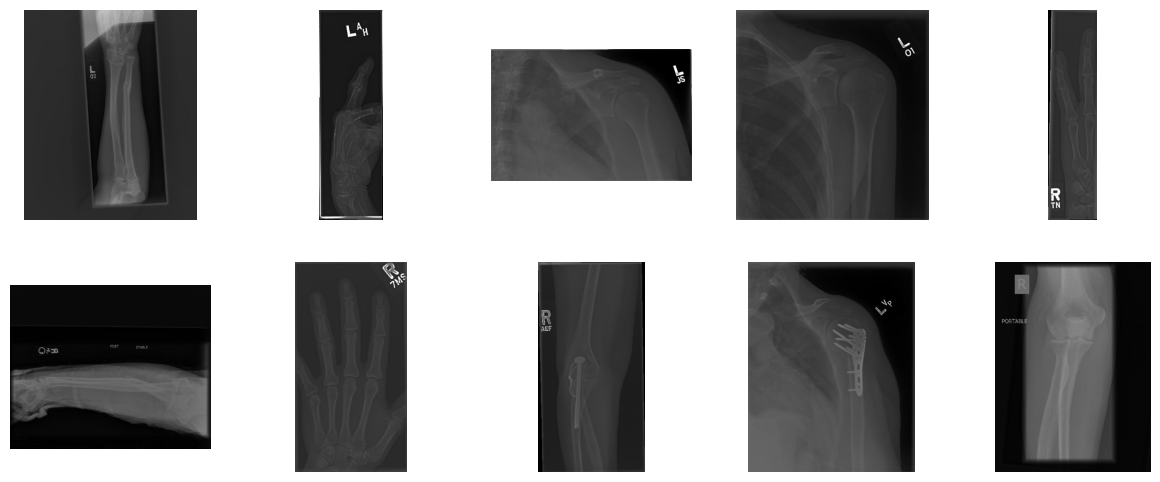

Displaying train images:


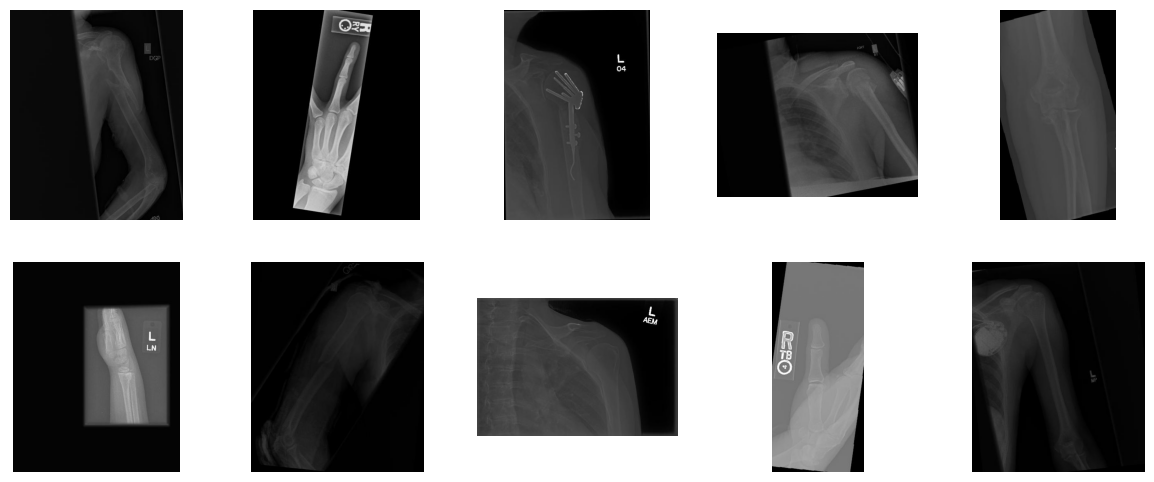

Displaying validation images:


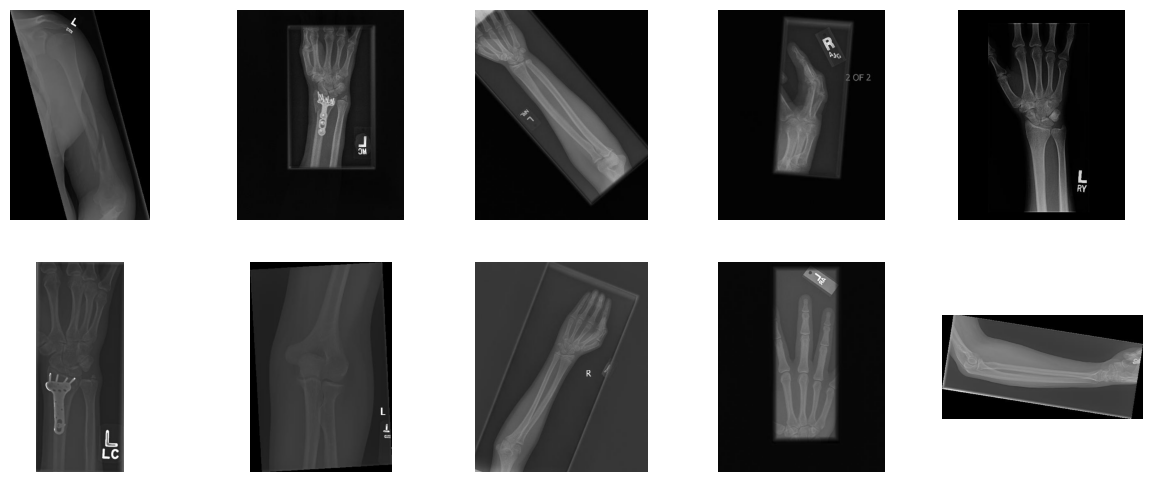

In [23]:
# Use display_image function on each dataset
print("Displaying test images:")
display_images(test_dir)

print("Displaying train images:")
display_images(train_dir)

print("Displaying validation images:")
display_images(val_dir)

## Part II: Training ResNet18 Model to Classify Images
The code aims to train a deep learning model to classify images into two categories (binary classification) using a structured approach with data loading, preprocessing, model training, and evaluation.

### Imports
Imports the necessary libraries and modules for handling data, training, and GPU checking.

In [24]:
# Import necessary libraries                 
import random                   
from PIL import Image           
import torch                    
import torchvision              # For torchvision utilities
from torchvision import transforms, datasets, models
from torchvision.models import ResNet18_Weights
import torch.nn as nn           # For neural network layers
import torch.optim as optim     # For optimization algorithms
from torch.utils.data import Dataset, DataLoader  # For creating custom datasets
import tensorflow as tf         

### GPU Check
Uses TensorFlow to print the number of GPUs available, verifying the system’s capability to use GPU acceleration.

In [25]:
# Check if GPU is available for TensorFlow
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


### Custom Dataset 
Class Creates a class to handle loading images and transformations for preprocessing. Creates a CustomImageDataset class that inherits from torch.utils.data.Dataset. This class handles image loading, filtering specific file types (jpg, jpeg, png), and applying transformations. The __len__ method returns the number of images in the directory, and the __getitem__ method fetches an image by index, applying any defined transformations.

In [26]:
# Define a custom dataset class to load images
class CustomImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        # Filter images with specific file extensions
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith(('jpg', 'jpeg', 'png'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Get image file path and load it
        img_name = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')  # Convert to RGB format
        
        # Apply transformations if defined
        if self.transform:
            image = self.transform(image)
        
        return image

### Image Transformations
Defines transformations to resize and convert images to tensors.Specifies transformations to preprocess images, including resizing to 224x224 pixels and converting images to PyTorch tensors using torchvision.transforms.

In [27]:
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),   # Resize images to 224x224 pixels
    transforms.ToTensor()            # Convert images to PyTorch tensors
])

In [28]:
# Load datasets with transformations applied
train_dataset = CustomImageDataset(train_dir, transform=transform)
val_dataset = CustomImageDataset(val_dir, transform=transform)
test_dataset = CustomImageDataset(test_dir, transform=transform)

### Data Loaders
Defines DataLoader objects for each dataset (train, validation, test) to efficiently batch and shuffle data. DataLoader simplifies batching, enabling easier data handling during training.

In [29]:
# Create data loaders for each dataset
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Model Setup
Loads a pre-trained ResNet18 model from torchvision.models, which is a standard CNN. The model's output layer is modified to match the binary classification task by updating the final layer’s output to a single unit.

Note that I manually loaded ResNet18 default weights by storing it in my dataset inputs.  
/kaggle/input/resnet18-weights/resnet18-f37072fd.pth

In [36]:
# Load the ResNet-18 model architecture
model = models.resnet18()

# Load the weights from the uploaded dataset in the Kaggle working directory
weights_path = '/kaggle/input/resnet18-weights/resnet18-f37072fd.pth'
model.load_state_dict(torch.load(weights_path))

# Modify the final layer for your specific number of classes
num_classes = 1 #binary classification will output a probability score between 0 and 1
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Verify the model architecture
print(model)

/tmp/ipykernel_1157/1891691583.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_path))


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Device Selection
Selects either GPU or CPU as the computation device. The model is transferred to the selected device to optimize performance based on system capabilities.

In [37]:
# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [38]:
# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()    # Binary cross-entropy loss with logits
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

### Training Loop
Iterates through specified epochs for training the model. The model enters training mode, and for each batch:

- Moves images and labels to the selected device.
- Performs a forward pass to calculate outputs and compute binary cross-entropy loss.
- Conducts a backward pass to update model weights using the Adam optimizer.
- Calculates the cumulative loss per epoch, outputting the average loss to monitor training progress.

In [39]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images in train_loader:
        images = images.to(device)
        labels = torch.ones(images.size(0)).to(device)  # Binary labels (all set to 1 for simplicity)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs.squeeze(), labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
    
    # Calculate average loss per epoch
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

Epoch 1/10, Loss: 0.0254
Epoch 2/10, Loss: 0.0002
Epoch 3/10, Loss: 0.0001
Epoch 4/10, Loss: 0.0001
Epoch 5/10, Loss: 0.0001
Epoch 6/10, Loss: 0.0001
Epoch 7/10, Loss: 0.0000
Epoch 8/10, Loss: 0.0000
Epoch 9/10, Loss: 0.0000
Epoch 10/10, Loss: 0.0000


### Validation Loop
Switches the model to evaluation mode and calculates the validation loss without gradients, ensuring no updates occur. Each batch is passed through the model, and loss is calculated and accumulated, yielding the average validation loss to gauge model performance on unseen data.

In [40]:
# Validation step
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    val_loss = 0.0
    for images in val_loader:
        images = images.to(device)
        labels = torch.ones(images.size(0)).to(device)
        
        # Validation forward pass
        outputs = model(images)
        loss = criterion(outputs.squeeze(), labels)
        
        val_loss += loss.item() * images.size(0)
    
    # Calculate average validation loss
    avg_val_loss = val_loss / len(val_loader.dataset)
    print(f'Validation Loss: {avg_val_loss:.4f}')

Validation Loss: 0.0000
